In [2]:
import os
from pathlib import Path

def root_dir(marker="EXPLib"):
    cwd = Path.cwd()
    # if cwd already contains the marker
    if (cwd / marker).is_dir():
        return cwd
    # otherwise walk up the parents
    for p in cwd.parents:
        if (p / marker).is_dir():
            return p
    raise FileNotFoundError(f"Root marker '{marker}' not found")

os.chdir(root_dir())
#print(os.getcwd())

In [3]:
import torch
import os
import cv2
import numpy as np
from PIL import Image
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image
from EXPLib.xai_library.model_explainers.model_utils.toymodel_utils import load_and_configure_model, preprocess_image, perform_inference_and_visualize
from EXPLib.xai_library.model_explainers.cam.toymodel_cam.toymodel_cam_utils import ToyModelScoreTarget, draw_boxes, predict, toymodel_reshape_transform

In [4]:
image_path = 'EXPLib/datasets/Camera/toy_model_v1_inference/dev/images'
image_file = 'rgb_0000100.png'
weight_path = 'EXPLib/dl_component/CNN/Object_Detectors/toy_model_v1'
weight_file = 'aikonet_toymodelv1_ssdlite.pth'

model_name = 'ssdlite320_mobilenet_v3_large'
num_classes = 2

############################################################################
# Check if a GPU is available and if not, use a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# load model
model = load_and_configure_model(model_name, weight_path, weight_file, num_classes, device)
model.eval()
# load image
image = preprocess_image(image_path, image_file, device)
processed_torch_inputs=image

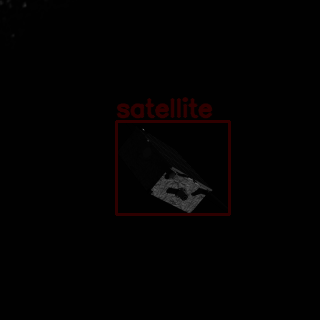

In [6]:
orig_image = cv2.imread(os.path.join(image_path, image_file))
boxes, classes, labels, indices = predict(processed_torch_inputs, model, device, 0.9)
bbox_image = draw_boxes(boxes, labels, classes, orig_image)
Image.fromarray(bbox_image)

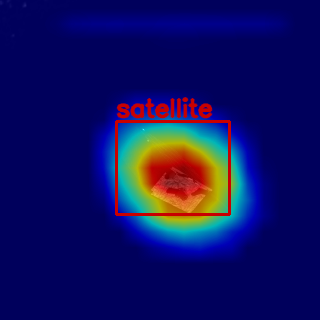

In [7]:
target_layers = [model.backbone]
labels=[1]
targets = [ToyModelScoreTarget(labels=labels, bounding_boxes=boxes)]
cam = EigenCAM(model,
              target_layers,
              reshape_transform=toymodel_reshape_transform)
grayscale_cam = cam(image, targets=targets)
# Take the first image in the batch:
grayscale_cam = grayscale_cam[0, :]
image_float_np = np.float32(orig_image) / 255
cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)
Image.fromarray(image_with_bounding_boxes)